In [41]:

import numpy as np
import matplotlib.pyplot as plt

import src.python.yalefaces as yalefaces

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import ConfusionMatrixDisplay

np.random.seed(15)

## Data preprocessing

### Load dataset

In [2]:
X, y = yalefaces.load("datasets/yalefaces", flatten=True)

### Plot dataset

<Figure size 432x288 with 0 Axes>

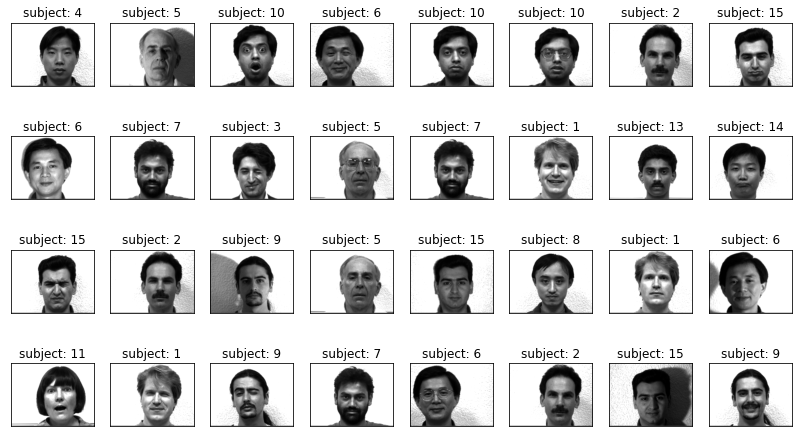

In [3]:
num_faces, num_pixels = X.shape

plt.figure()
f, axes = plt.subplots(4,8, figsize=(14, 8), sharey=True)

for ax in axes:
    for axy in ax:
        # select a random face
        face = np.random.randint(0, num_faces)
        
        # format image and label as in the raw dataset
        face_img = X[face].reshape(yalefaces.SHAPE)
        face_label = y[face] + 1

        # plot face
        axy.imshow(face_img, cmap='gray')
        
        # show only relevant information
        axy.set_title(f"subject: {face_label}")
        axy.set_xticks([])
        axy.set_yticks([])
plt.show()

### Identify most relevant pixels

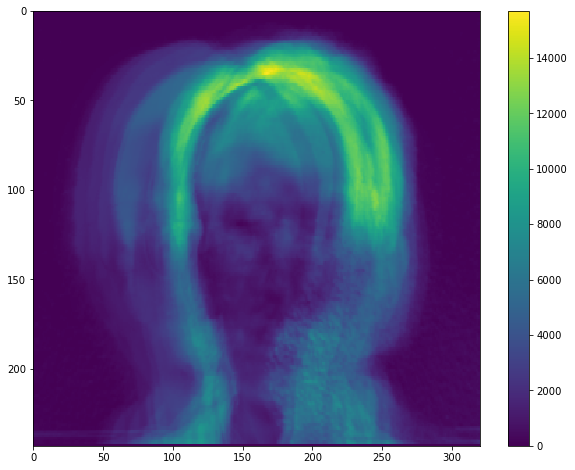

In [4]:
from sklearn.feature_selection import chi2

score, _ = chi2(X, y)
score_img = (np.array(score)).reshape(yalefaces.SHAPE)

plt.figure(figsize=(10, 8))

colormesh = plt.pcolormesh(score_img)
plt.colorbar(colormesh)

# mirror the y-axis because pcolormesh doesn't
# do this trick automatically as imgshow does.
plt.gca().invert_yaxis()
plt.show()

## Reduce number of dimensions

### Plot explained variance ratio

In [5]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X)

PCA()

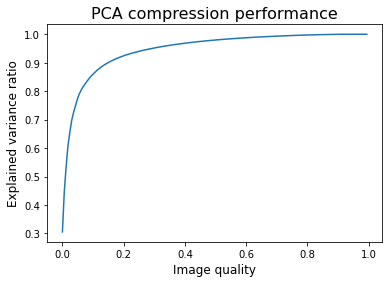

In [6]:
plt.plot(np.arange(num_faces)/165, np.cumsum(pca.explained_variance_ratio_))

plt.title("PCA compression performance", size=16)
plt.ylabel("Explained variance ratio", size=12)
plt.xlabel("Image quality", size=12)

plt.show()

### Choose image quality and compress images with PCA

In [7]:
image_quality = 1
n_components = int(num_faces * image_quality)

pca = PCA(n_components=n_components)
pca.fit(X)
X_compressed = pca.transform(X)
X_reconstructed = pca.inverse_transform(X_compressed)

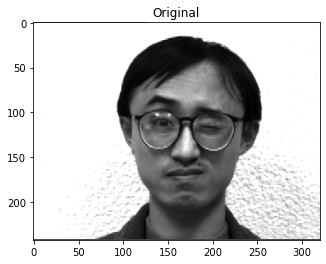

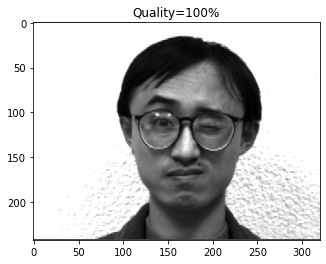

In [8]:
plt.imshow(X[0].reshape(yalefaces.SHAPE), cmap="gray")
plt.title("Original")
plt.show()

plt.imshow(X_reconstructed[0].reshape(yalefaces.SHAPE), cmap="gray")
plt.title(f"Quality={image_quality*100}%")
plt.show()

### Prepare datasets (original and compressed)

In [10]:
from sklearn.model_selection import train_test_split

# original
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)

# compressed
X_train_compressed, X_test_compressed, y_train_compressed, y_test_compressed = train_test_split(X_compressed, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)

## Logistic Regression

### Train and test on the original dataset

In [11]:
lr_classifier = LogisticRegression(C=0.1, random_state=0, max_iter=7600).fit(X_train, y_train)

Score (original): 0.92


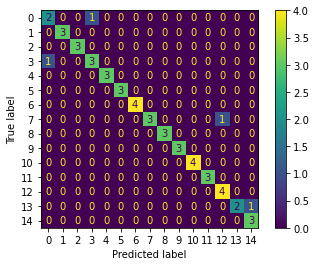

In [12]:
print("Score (original):", lr_classifier.score(X_test, y_test))

lr_pred = lr_classifier.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, lr_pred)

### Train and test on the compressed dataset

In [124]:
lr_classifier_compressed = LogisticRegression(C=0.1, random_state=42).fit(X_train_compressed, y_train_compressed)

Score (compressed): 0.88


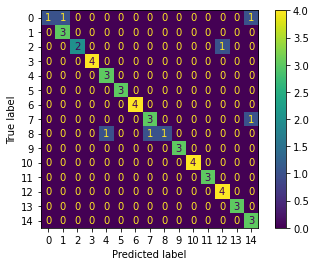

In [125]:
print("Score (compressed):", lr_classifier_compressed.score(X_test_compressed, y_test_compressed))

lr_pred_compressed = lr_classifier_compressed.predict(X_test_compressed)
ConfusionMatrixDisplay.from_predictions(y_test_compressed, lr_pred_compressed)

## KNN

### Train and test on the original dataset

In [33]:
knn_classifier = KNeighborsClassifier(n_neighbors=2)
knn_classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2)

Score (original): 0.8


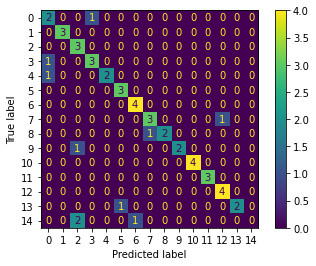

In [34]:
print("Score (original):", knn_classifier.score(X_test, y_test))

knn_pred = knn_classifier.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, knn_pred)

### Train and test on the compressed dataset

In [38]:
knn_classifier_compressed = KNeighborsClassifier(n_neighbors=2)
knn_classifier_compressed.fit(X_train_compressed, y_train_compressed)

KNeighborsClassifier(n_neighbors=2)

Score (compressed): 0.8


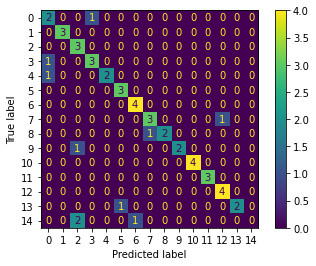

In [39]:
print("Score (compressed):", knn_classifier_compressed.score(X_test_compressed, y_test_compressed))

knn_pred_compressed = knn_classifier_compressed.predict(X_test_compressed)
ConfusionMatrixDisplay.from_predictions(y_test_compressed, knn_pred_compressed)

## Neural Networks

### Train and test on the original dataset

In [77]:
mlp_classifier = MLPClassifier(solver='adam', learning_rate_init=0.001, random_state=1)
mlp_classifier.fit(X_train, y_train)

MLPClassifier(random_state=1)

Score (original): 0.36


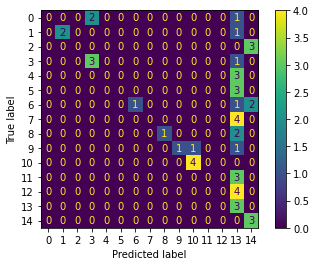

In [76]:
print("Score (original):", mlp_classifier.score(X_test, y_test))

mlp_pred= mlp_classifier.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, mlp_pred)

### Train and test on the compressed dataset

In [78]:
mlp_classifier_compressed = MLPClassifier(solver='adam', learning_rate_init=0.1, random_state=1)
mlp_classifier_compressed.fit(X_train_compressed, y_train_compressed)

MLPClassifier(learning_rate_init=0.1, random_state=1)

Score (compressed): 0.8


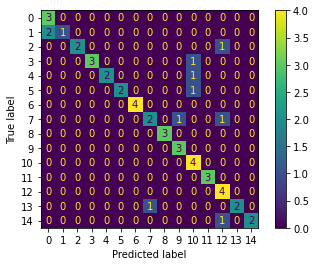

In [79]:
print("Score (compressed):", mlp_classifier_compressed.score(X_test_compressed, y_test_compressed))

mlp_pred_compressed = mlp_classifier_compressed.predict(X_test_compressed)
ConfusionMatrixDisplay.from_predictions(y_test_compressed, mlp_pred_compressed)

## Convolutional Neural Networks